---
# Create MOM6 LGM tidal energy file
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [xesmf](https://github.com/pangeo-data/xESMF)
  - [pop_tools](https://pop-tools.readthedocs.io/en/latest/)
- References
  - [MOM6 Manual](https://mom6.readthedocs.io/en/main/api/generated/pages/Internal_Vert_Mixing.html#internal-vert-mixing-1section-internal-tidal-mixing)
  - [Wilmes et al. (2019)]( https://doi.org/10.1029/2019PA003644)
- This step depends on the LGM Topo file from create_mom6_bathy.ipynb
---

In [1]:
import subprocess
import datetime
import copy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import xesmf
import pop_tools

import warnings
warnings.filterwarnings('ignore')

/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


---
## Input

### High-res. tidal model results from [Wilmes et al. (2019)](https://doi.org/10.1029/2019PA003644)
- Data downloaded from [zenodo](https://zenodo.org/records/1139242)

In [2]:
tide_cases = {}

data_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/lgm_tidal'

tide_cases['wilmes_pi'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_00kyrBP_-I6.0_7672998.nc'}

tide_cases['wilmes_21ka_i6g'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_21kyrBP_i6g_-t_-I6.0_7673000.nc'}

tide_cases['wilmes_21ka_i5g'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_21kyrBP_i5g_-t_-I6.0_7672999.nc'}

### MOM6 files: grid, geometry, preindustrial tidal, and LGM topo

<xarray.Dataset> Size: 6MB
Dimensions:  (ny: 480, nx: 540, lon: 540, lat: 480, lon_b: 541, lat_b: 481)
Coordinates:
  * lon      (lon) float64 4kB -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * lat      (lat) float64 4kB -81.56 -81.46 -81.36 -81.26 ... 89.33 89.6 89.86
  * lon_b    (lon_b) float64 4kB -287.0 -286.3 -285.7 ... 71.67 72.33 73.0
  * lat_b    (lat_b) float64 4kB -81.61 -81.51 -81.41 ... 89.46 89.72 89.91
Dimensions without coordinates: ny, nx
Data variables:
    y        (ny, nx) float64 2MB ...
    x        (ny, nx) float64 2MB ...
    mask     (ny, nx) int32 1MB ...
    depth    (ny, nx) float32 1MB ...
Attributes:
    date_created:  2025-09-22T12:22:04.264856
    title:         LGM bathymetry file for MOM6 by Jiang Zhu (jiangzhu@ucar.e...
    min_depth:     2.5
    max_depth:     8008.71923828125

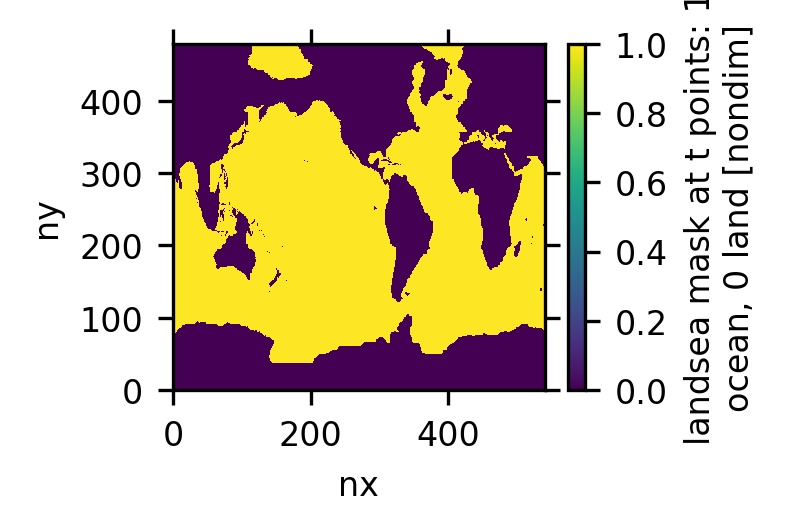

In [3]:

mom6_grid = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_topo_tx2_3v2_240501.nc')
mom6_grid = mom6_grid.rename({'lonh': 'lon', 'lath': 'lat',
                              'lonq': 'lon_b', 'latq': 'lat_b'})

ds_mom_geom = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_geometry.nc')

ds_mom_pre = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/energy_new_tx2_3_conserve_230415_cdf5.nc')


mom6_lgm_topo = xr.open_dataset('/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2/ocean_topo_tx2_3v2_240501_21ka_250922.nc')

mom6_lgm_topo['lon'] = mom6_grid.lon
mom6_lgm_topo['lat'] = mom6_grid.lat
mom6_lgm_topo['lon_b'] = mom6_grid.lon_b  # Needed for conservative regridding
mom6_lgm_topo['lat_b'] = mom6_grid.lat_b  # Needed for conservative regridding

mom6_lgm_topo.mask.plot(size=1.5)
mom6_lgm_topo

---
## Output

In [4]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2'
mom_lgm_tidal = f"{work_dir}/tidal_energy_tx2_3_21ka_wilmes2019_ano_added_{today}.nc"

print(mom_lgm_tidal)

250922
/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2/tidal_energy_tx2_3_21ka_wilmes2019_ano_added_250922.nc


---
## Explore the data: compute the global integration of Wilmes et al. and make plots

In [5]:
for key in tide_cases.keys():

    tide_file = f"{tide_cases[key]['data_dir']}/{tide_cases[key]['fname']}"
    ds = xr.open_dataset(tide_file).rename(
        {'LATITUDE': 'lat', 'LONGITUDE': 'lon'}).squeeze()

    lat = np.deg2rad(ds.lat.values)
    lon = np.deg2rad(ds.lon.values)
    d_lat = np.diff(lat)[0]
    d_lon = np.diff(lon)[0]
    R = 6371000.0
    area = np.cos(lat) * (R ** 2) * d_lat * d_lon

    # Apply land-sea mask?
    ds.diss.data = xr.where(ds.mz == 1, ds.diss, np.nan)

    diss_x_A = ds.diss * area / 1e12

    diss_ttl = diss_x_A.sum()
    print(f"{key} total diss: {diss_ttl:3.2f} TW, min={ds.diss.min().values:5.2f}, max={ds.diss.max().values:5.2f}")

    # diss_ttl2 = ((ds.EDM2 + ds.EDS2 + ds.EDK1 + ds.EDO1) * area).sum(
    #     dim=['lat', 'lon']).values / 1e12
    # print(f"{key} total diss (M2+S2+K1+O1): {diss_ttl2:3.2f} TW")

    diss_ttl_deep = diss_x_A.where(ds.hz > 500).sum()
    print(f"{key} deep diss (z > 500 m): {diss_ttl_deep:3.2f} TW")

    ds['diss_ttl'] = diss_ttl
    ds['diss_ttl_deep'] = diss_ttl_deep
    tide_cases[key]['ds'] = ds


wilmes_pi total diss: 1.20 TW, min= 0.00, max=33.72
wilmes_pi deep diss (z > 500 m): 0.92 TW
wilmes_21ka_i6g total diss: 2.42 TW, min= 0.00, max=62.38
wilmes_21ka_i6g deep diss (z > 500 m): 1.83 TW
wilmes_21ka_i5g total diss: 3.54 TW, min= 0.00, max=64.06
wilmes_21ka_i5g deep diss (z > 500 m): 2.86 TW


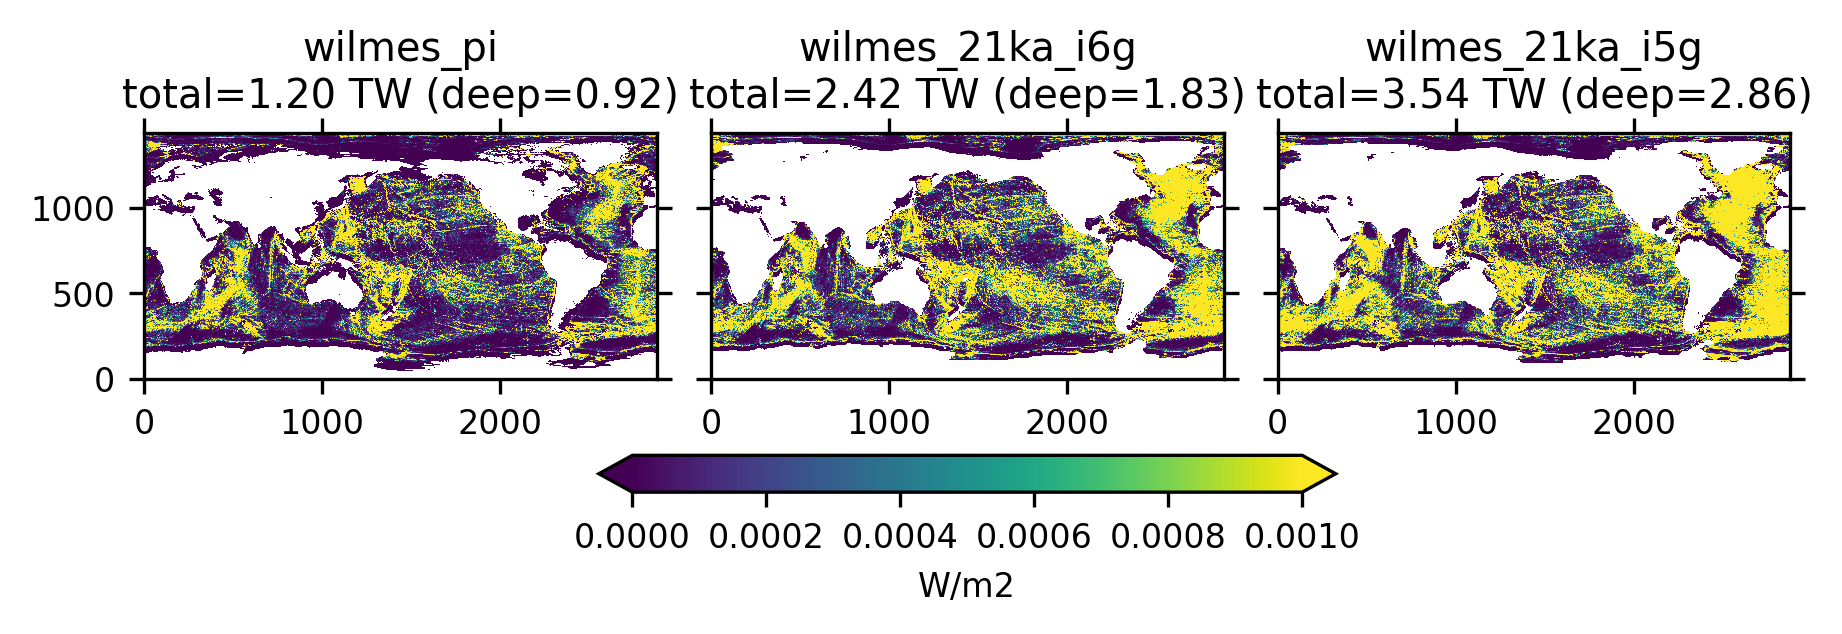

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, key in zip(axes.ravel(), tide_cases.keys()):

    ds = tide_cases[key]['ds']

    hc = ax.pcolormesh(ds.diss.T, vmin=0, vmax=0.001)

    title = f"{key}\ntotal={ds.diss_ttl:3.2f} TW (deep={ds.diss_ttl_deep:3.2f})"
    ax.set_title(title)

cb = fig.colorbar(hc, ax=axes, extend='both',
                  orientation='horizontal', shrink=0.5)
cb.set_label('W/m2')

- NOTE: Wilmes et al. tide model extends to 89°N, so there are missing values over the North Pole.

---
## Examine the POP and MOM PI files (derived from Steven Jayne's data)
### Read POP2 file and compute global integration
- Use pop_tools to get the gx1v6 grid 

In [7]:
ds_pop_pre = pop_tools.get_grid('POP_gx1v6')[['KMT', 'TAREA', 'z_t']]
nlat = len(ds_pop_pre.nlat)
nlon = len(ds_pop_pre.nlon)
print(ds_pop_pre.z_t[32].values/100)

data_tmp = np.fromfile(
    '/glade/campaign/cesm/cesmdata/inputdata/ocn/pop/gx1v6/forcing/tidal_energy_gx1v6_20090205.ieeer8',
    dtype='>f8', count=nlat*nlon
)
data_tmp = np.reshape(data_tmp, [nlon, nlat], order='F').T

print(f"POP max = {data_tmp.max()}, min={data_tmp.min()}")

data_tmp = np.where(data_tmp < -999, 0, data_tmp)
print(f"POP max (after masking) = {np.nanmax(data_tmp)}, min={np.nanmin(data_tmp)}")

ds_pop_pre['diss'] = ds_pop_pre.TAREA * 0 + data_tmp

482.7367289999999
POP max = 1.4844191074371338, min=-9.999999790214768e+33
POP max (after masking) = 1.4844191074371338, min=0.0


In [8]:
ds_pop_pre['diss'] = ds_pop_pre.diss.where(ds_pop_pre.KMT > 0)

diss_x_A = ds_pop_pre.diss * ds_pop_pre.TAREA / 1e16
ds_pop_pre['diss_ttl'] = diss_x_A.where(ds_pop_pre.KMT > 0).sum()
ds_pop_pre['diss_ttl_deep'] = diss_x_A.where(ds_pop_pre.KMT > 33).sum()

print(f"POP total diss: {ds_pop_pre.diss_ttl:3.2f} TW, max={ds_pop_pre.diss.max().values:5.2f}, min={ds_pop_pre.diss.min().values:5.2f}")

ds_pop_pre

POP total diss: 1.92 TW, max= 1.48, min= 0.00


<xarray.Dataset> Size: 2MB
Dimensions:        (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t            (z_t) float64 480B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT            (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    TAREA          (nlat, nlon) float64 983kB 1.125e+13 1.125e+13 ... 7.432e+12
    diss           (nlat, nlon) float64 983kB nan nan nan nan ... nan nan nan
    diss_ttl       float64 8B 1.924
    diss_ttl_deep  float64 8B 1.553
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

### Read the MOM6 file and compute global integration
- Use MOM geometry file to get the area and depth

In [9]:
ds_mom_pre['wave_dissipation'] = ds_mom_pre.wave_dissipation.where(
    ds_mom_geom.wet.values > 0)

diss_x_A = ds_mom_pre.wave_dissipation * ds_mom_geom.Ah.values / 1e12
ds_mom_pre['diss_ttl'] = diss_x_A.where(ds_mom_geom.D.values > 0).sum()
ds_mom_pre['diss_ttl_deep'] = diss_x_A.where(ds_mom_geom.D.values > 500).sum()

print(f"MOM min={ds_mom_pre.wave_dissipation.min().values}, max={ds_mom_pre.wave_dissipation.max().values}")

ds_mom_pre

MOM min=0.0, max=2.1758829595309237


<xarray.Dataset> Size: 6MB
Dimensions:           (ny: 480, nx: 540)
Coordinates:
    lon               (ny, nx) float64 2MB ...
    lat               (ny, nx) float64 2MB ...
Dimensions without coordinates: ny, nx
Data variables:
    wave_dissipation  (ny, nx) float64 2MB nan nan nan nan ... nan nan nan nan
    diss_ttl          float64 8B 1.916
    diss_ttl_deep     float64 8B 1.482
Attributes:
    description:  Estimated tidal dissipation data by S.R. Jayne. WHOI.
    author:       Alper Altuntas (altuntas@ucar.edu)
    created:      2023-16-04 14:52:43

### Make plot

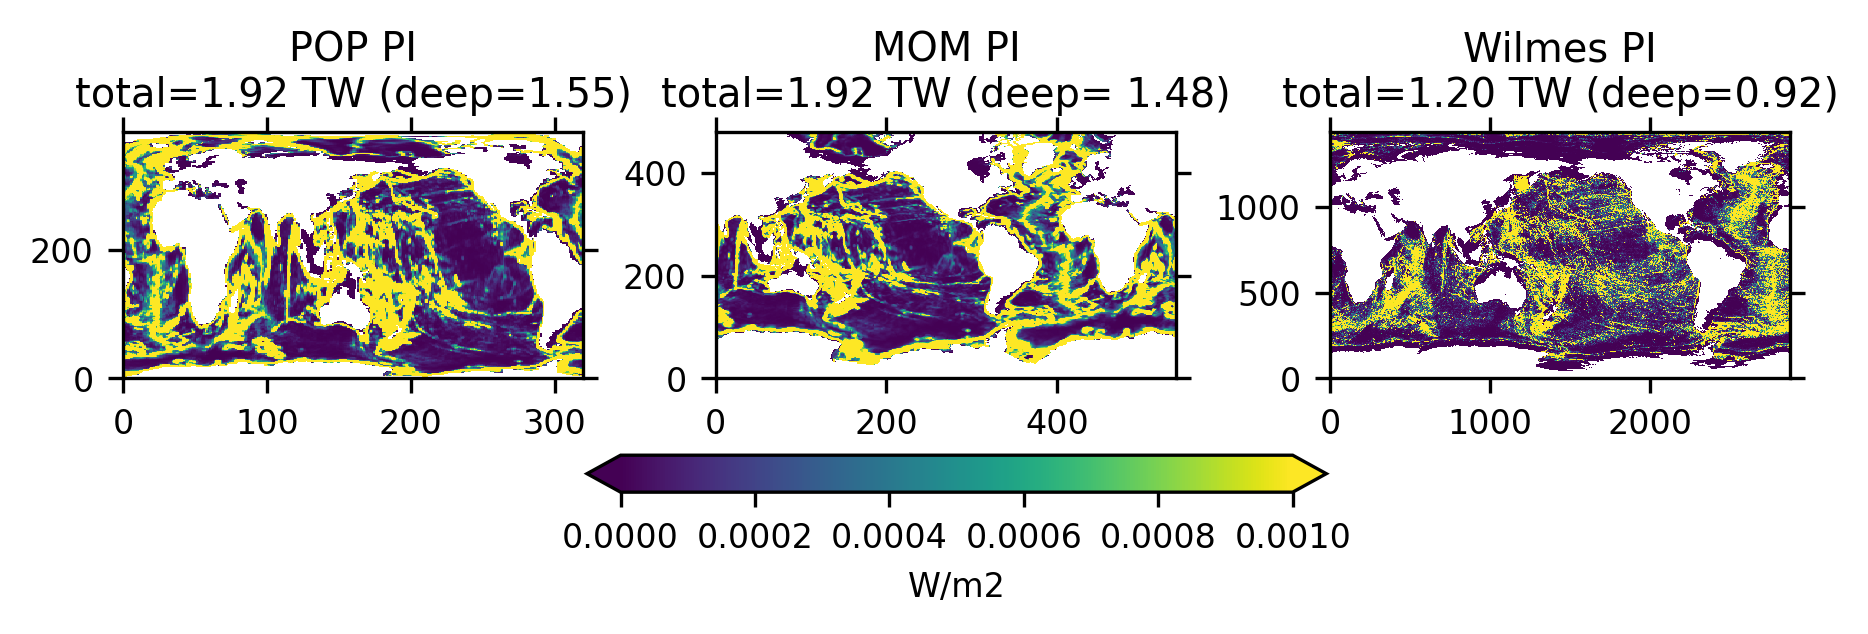

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2),
                         sharex=False, sharey=False,
                         constrained_layout=True)

ax = axes[0]
hc = ax.pcolormesh(ds_pop_pre.diss, vmin=0, vmax=0.001)
ax.set_title(f"POP PI\ntotal={ds_pop_pre.diss_ttl:3.2f} TW (deep={ds_pop_pre.diss_ttl_deep:3.2f})")

ax = axes[1]
hc = ax.pcolormesh(ds_mom_pre.wave_dissipation, vmin=0, vmax=0.001)
ax.set_title(f"MOM PI\ntotal={ds_mom_pre.diss_ttl:3.2f} TW (deep={ds_mom_pre.diss_ttl_deep: 3.2f})")

ax = axes[2]
ds = tide_cases['wilmes_pi']['ds']
hc = ax.pcolormesh(ds.diss.T, vmin=0, vmax=0.001)
ax.set_title(f"Wilmes PI\ntotal={ds.diss_ttl:3.2f} TW (deep={ds.diss_ttl_deep:3.2f})")

cb = fig.colorbar(hc, ax=axes, extend='both',
                  orientation='horizontal', shrink=0.5,)
cb.set_label('W/m2')

---
## Main step: Derive anomaly (Wilmes_LGM - Wilmes_PI), scale it and add it to Jayne's PI

In [11]:
scale_factor = ds_mom_pre.diss_ttl / tide_cases['wilmes_pi']['ds'].diss_ttl
print(f"scale factor = {scale_factor:3.2f}")

scale factor = 1.59


In [12]:
ds_wilmes_ano = (tide_cases['wilmes_21ka_i6g']['ds'] - tide_cases['wilmes_pi']['ds'])[['diss']]
ds_wilmes_ano['diss'] = ds_wilmes_ano.diss.fillna(0)

# Don't add mask here
# ds_wilmes_ano['mask'] = xr.where(tide_cases['wilmes_21ka_i6g']['ds'].hz > 0, 1, 0).T

ds_wilmes_ano['lon_b'] = np.linspace(0, 360, 2881)
ds_wilmes_ano['lat_b'] = np.linspace(-90, 90, 1441)

print(f"Anomaly min={ds_wilmes_ano.diss.min().values}, max={ds_wilmes_ano.diss.max().values}")
ds_wilmes_ano

Anomaly min=-25.28262990642742, max=54.61195525023083


<xarray.Dataset> Size: 33MB
Dimensions:  (lon: 2880, lat: 1440, lon_b: 2881, lat_b: 1441)
Coordinates:
  * lat      (lat) float64 12kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * lon      (lon) float64 23kB 0.0625 0.1875 0.3125 ... 359.7 359.8 359.9
  * lon_b    (lon_b) float64 23kB 0.0 0.125 0.25 0.375 ... 359.8 359.9 360.0
  * lat_b    (lat_b) float64 12kB -90.0 -89.88 -89.75 ... 89.75 89.88 90.0
Data variables:
    diss     (lon, lat) float64 33MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [13]:
%%time

regridder = xesmf.Regridder(
    ds_wilmes_ano,
    mom6_lgm_topo,
    method='conservative_normed',
    # method='conservative',
    # method='bilinear',
    # method='patch',
    # extrap_method="nearest_s2d",
    periodic=True)

diss_wilmes_ano_mom = regridder(ds_wilmes_ano['diss'])

CPU times: user 1min 5s, sys: 1.96 s, total: 1min 7s
Wall time: 1min 7s


In [14]:
ds_mom_lgm = ds_mom_pre.copy(deep=True)

ds_mom_lgm.wave_dissipation.data = ds_mom_pre.wave_dissipation + \
    diss_wilmes_ano_mom.data * scale_factor.values

### Fill missing values with nearest neighbor, apply mask again, and remove negative values

In [15]:
def fill_na(ds, n_points):
    for varname in ds.data_vars:
        while ds[varname].isnull().any():
            ds[varname] = ds[varname].ffill(dim='nx', limit=n_points)
            ds[varname] = ds[varname].bfill(dim='nx', limit=n_points)
            ds[varname] = ds[varname].ffill(dim='ny', limit=n_points)
            ds[varname] = ds[varname].bfill(dim='ny', limit=n_points)
    return ds

ds_mom_lgm = fill_na(ds_mom_lgm, n_points=1)

In [16]:
ds_mom_lgm['wave_dissipation'] = ds_mom_lgm.wave_dissipation.where(
    mom6_lgm_topo.mask.values > 0)

ds_mom_lgm['wave_dissipation'] = xr.where(
    ds_mom_lgm.wave_dissipation < 0, 0, ds_mom_lgm.wave_dissipation)

### Compute the global integration

In [17]:
diss_x_A = ds_mom_lgm.wave_dissipation * ds_mom_geom.Ah.values / 1e12
ds_mom_lgm['diss_ttl'] = diss_x_A.where(mom6_lgm_topo.depth.values > 0.0).sum()
ds_mom_lgm['diss_ttl_deep'] = diss_x_A.where(mom6_lgm_topo.depth.values > 500.0).sum()

print(f"MOM min={ds_mom_lgm.wave_dissipation.min().values}, max={ds_mom_lgm.wave_dissipation.max().values}")

ds_mom_lgm

MOM min=0.0, max=24.846938129183744


<xarray.Dataset> Size: 6MB
Dimensions:           (ny: 480, nx: 540)
Coordinates:
    lon               (ny, nx) float64 2MB -286.7 -286.0 -285.3 ... 72.98 73.0
    lat               (ny, nx) float64 2MB -81.56 -81.56 -81.56 ... 50.11 49.99
Dimensions without coordinates: ny, nx
Data variables:
    wave_dissipation  (ny, nx) float64 2MB nan nan nan nan ... nan nan nan nan
    diss_ttl          float64 8B 3.912
    diss_ttl_deep     float64 8B 3.137
Attributes:
    description:  Estimated tidal dissipation data by S.R. Jayne. WHOI.
    author:       Alper Altuntas (altuntas@ucar.edu)
    created:      2023-16-04 14:52:43

### Make plot

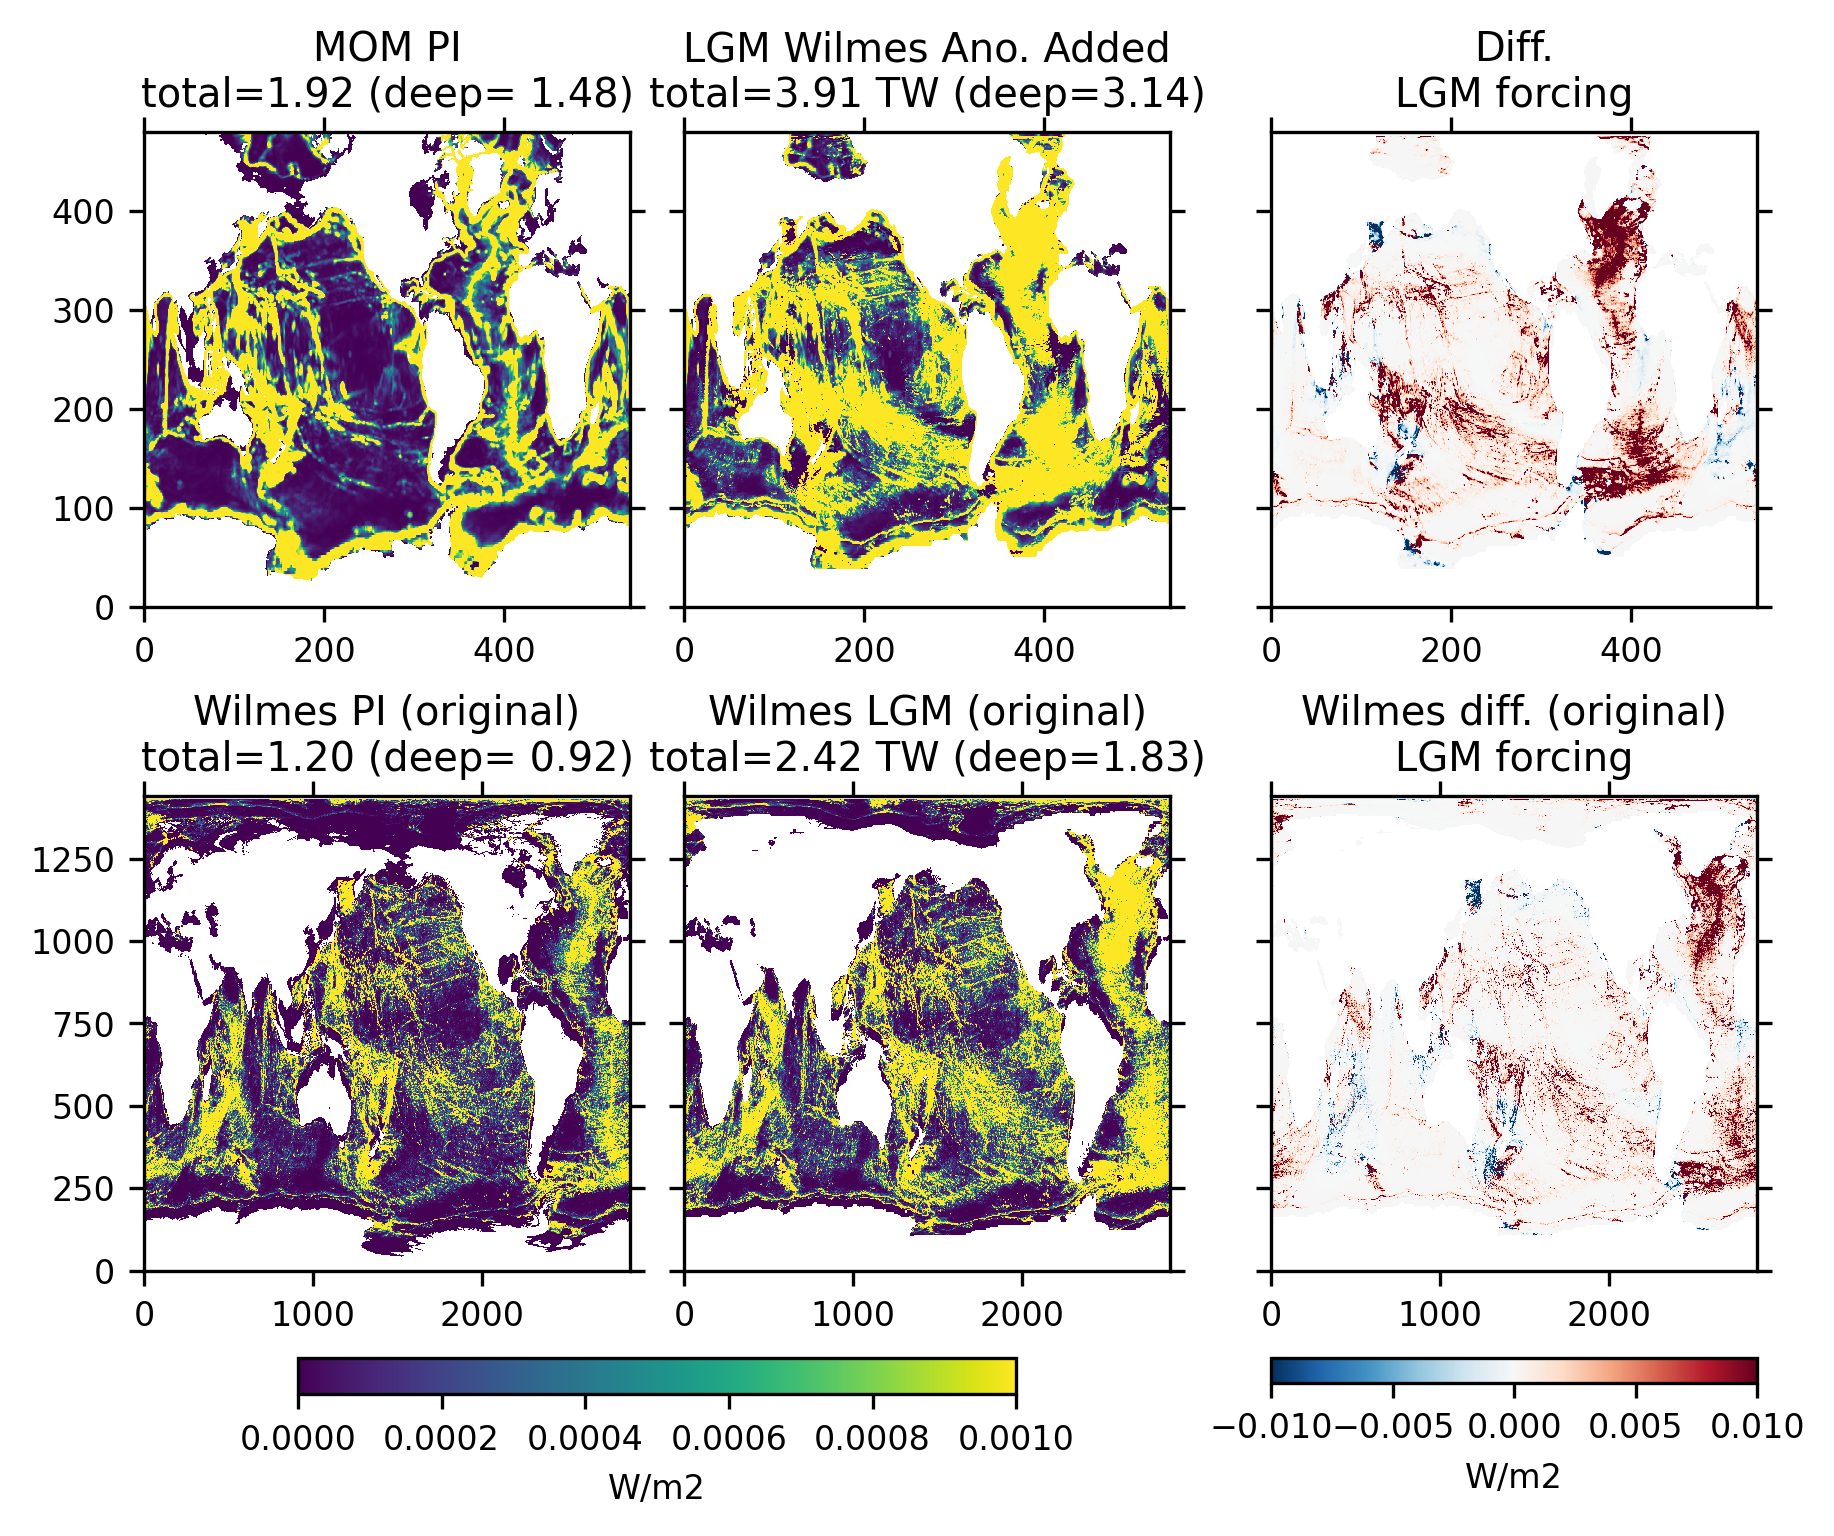

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(6, 5),
                         sharex=False, sharey='row',
                         constrained_layout=True)
axes = axes.ravel()

levels=np.linspace(-0.1, 0.1, 21)

ax = axes[0]
hc = ax.pcolormesh(ds_mom_pre.wave_dissipation, vmin=0, vmax=0.001)
ax.set_title(f"MOM PI\ntotal={ds_mom_pre.diss_ttl:3.2f} (deep={ds_mom_pre.diss_ttl_deep: 3.2f})")

ax = axes[1]
hc = ax.pcolormesh(ds_mom_lgm.wave_dissipation, vmin=0, vmax=0.001)
ax.set_title(f"LGM Wilmes Ano. Added\ntotal={ds_mom_lgm.diss_ttl:3.2f} TW (deep={ds_mom_lgm.diss_ttl_deep:3.2f})")

ax = axes[2]
hc = ax.pcolormesh(ds_mom_lgm.wave_dissipation - ds_mom_pre.wave_dissipation,
                   vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax.set_title("Diff.\nLGM forcing")

ax = axes[3]
ds = tide_cases['wilmes_pi']['ds']
hc = ax.pcolormesh(ds.diss.T, vmin=0, vmax=0.001)
ax.set_title(f"Wilmes PI (original)\ntotal={ds.diss_ttl:3.2f} (deep={ds.diss_ttl_deep: 3.2f})")

ax = axes[4]
ds = tide_cases['wilmes_21ka_i6g']['ds']
hc = ax.pcolormesh(ds.diss.T, vmin=0, vmax=0.001)
ax.set_title(f"Wilmes LGM (original)\ntotal={ds.diss_ttl:3.2f} TW (deep={ds.diss_ttl_deep:3.2f})")

ax = axes[5]
ds = tide_cases['wilmes_21ka_i6g']['ds'] - tide_cases['wilmes_pi']['ds']
hc2 = ax.pcolormesh(ds.diss.T, vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax.set_title("Wilmes diff. (original)\nLGM forcing")

cb = fig.colorbar(hc, ax=axes[3:5], orientation='horizontal', shrink=0.7,)
cb.set_label('W/m2')

cb2 = fig.colorbar(hc2, ax=axes[5], orientation='horizontal', shrink=1,)
cb2.set_label('W/m2')

---
## Save netcdf data

In [19]:
ds_mom_lgm.attrs = {}
ds_mom_lgm.attrs['Title'] = 'CESM3 LGM tidal energy file'
ds_mom_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_mom_lgm.attrs['Source_files_from'] = 'Wilmes_et_al_2019'
ds_mom_lgm.attrs['Script'] = 'create_mom6_tidal.ipynb'
ds_mom_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3_lgm'
ds_mom_lgm.attrs["Date_created"] = datetime.datetime.now().isoformat()

ds_mom_lgm['wave_dissipation'] = ds_mom_lgm.wave_dissipation.fillna(0)
ds_mom_lgm.to_netcdf(mom_lgm_tidal, format="NETCDF3_64BIT")